# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = DEFAULT_ANALYSIS  # Analysis type
mouseline = 'sst'  # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
ykey_classification = Label.DFF  # Variable of interest for post-processing
ykeys_plt = [Label.DFF]# , Label.ZSCORE, Label.EVENT_RATE]  # Plotting variables

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    ykey_classification)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 05/12/2022 16:30:38: assembling batch analysis settings...
 05/12/2022 16:30:38: sst main analysis notebook started on 2022-12-05 at 16:30:38


### Input summary table figure

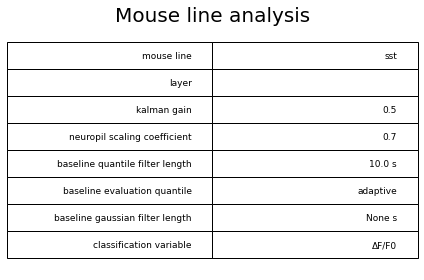

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification
    }, title='Mouse line analysis')

### Load data

In [50]:
# Determine exclude patterns
exclude_patterns = {
    'sst': [
        '20190706_mouse7_region1',  
        # - lots of double activations
        # - large synced activations with significant delays...
        # - huge average response at 0.1 MPa (i.e. significantly below excitation thresold)
        # - bad stimulus sync? or bad electrical isolation?
        # '20190808_mouse6_region1',
        # - double activations all over the place 
        # - lots of motion artefact all across initial run 
        # - result of bad stimulus sync? electrocution?
        # '20190701_mouse1_region1', # test
    ],
    'line3': [

    ],
    'pv': [

    ]
}[mouseline]

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(stats)

 05/12/2022 18:13:06: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/classΔFF0/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/sst:
 05/12/2022 18:13:06: excluding datasets with the following patterns:
 - 20190706_mouse7_region1
 05/12/2022 18:13:06: loading trial-averaged data from 20190628_mouse2_region1.h5
 05/12/2022 18:13:07: loading trial-averaged data from 20190629_mouse3_region1.h5
 05/12/2022 18:13:07: loading trial-averaged data from 20190701_mouse1_region1.h5
 05/12/2022 18:13:07: loading trial-averaged data from 20190808_mouse6_region1.h5
 05/12/2022 18:13:07: loading trial-averaged data from 20190808_mouse7_region2.h5
 05/12/2022 18:13:07: loading trial-averaged data from 20190808_mouse8_region1.h5
 05/12/2022 18:13:08: gathering dataset IDs...
 05/12/2022 18:13:08: sorting dataset indexes...
 05/12/2022 18:13:08: checking for run order consistency across datasets...
 05/12/2022 18:13:08:

### Inspect parametric sequences per dataset

In [48]:
get_param_sequence_per_dataset(stats)

dataset 20190628_mouse2_region1 20190629_mouse3_region1  \
run ID                                                    
0                 0.80MPa_30%DC           0.80MPa_50%DC   
1                 0.80MPa_20%DC           0.80MPa_40%DC   
2                 0.80MPa_10%DC           0.80MPa_30%DC   
3                 0.80MPa_05%DC           0.80MPa_20%DC   
4                 0.00MPa_50%DC           0.80MPa_10%DC   
5                 0.60MPa_50%DC           0.80MPa_05%DC   
6                 0.40MPa_50%DC           0.00MPa_50%DC   
7                 0.20MPa_50%DC           0.60MPa_50%DC   
8                 0.10MPa_50%DC           0.40MPa_50%DC   
9                           NaN           0.20MPa_50%DC   
10                0.80MPa_60%DC           0.10MPa_50%DC   
11                0.80MPa_70%DC           0.80MPa_60%DC   
12                0.80MPa_80%DC           0.80MPa_70%DC   
13                          NaN           0.80MPa_80%DC   
14                          NaN                     NaN   

dataset 20190701_mouse1_region1 20190808_mouse6_region1  \
run ID                                                    
0                 0.80MPa_50%DC           0.80MPa_40%DC   
1                 0.80MPa_40%DC           0.80MPa_30%DC   
2                 0.80MPa_30%DC           0.80MPa_20%DC   
3                 0.80MPa_20%DC           0.80MPa_10%DC   
4                 0.80MPa_10%DC           0.80MPa_05%DC   
5                 0.80MPa_05%DC           0.60MPa_50%DC   
6                 0.00MPa_50%DC           0.40MPa_50%DC   
7                 0.60MPa_50%DC           0.20MPa_50%DC   
8                 0.40MPa_50%DC           0.10MPa_50%DC   
9                 0.20MPa_50%DC           0.05MPa_50%DC   
10                0.10MPa_50%DC           0.00MPa_50%DC   
11                0.05MPa_50%DC           0.80MPa_60%DC   
12                0.80MPa_60%DC           0.80MPa_70%DC   
13                0.80MPa_70%DC           0.80MPa_80%DC   
14                0.80MPa_80%DC                     NaN   

dataset 20190808_mouse7_region2 20190808_mouse8_region1  
run ID                                                   
0                 0.80MPa_50%DC           0.80MPa_50%DC  
1                 0.80MPa_40%DC           0.80MPa_40%DC  
2                 0.80MPa_30%DC           0.80MPa_30%DC  
3                 0.80MPa_20%DC           0.80MPa_20%DC  
4                 0.80MPa_10%DC           0.80MPa_10%DC  
5                 0.80MPa_05%DC           0.80MPa_05%DC  
6                 0.60MPa_50%DC           0.60MPa_50%DC  
7                 0.40MPa_50%DC           0.40MPa_50%DC  
8                 0.20MPa_50%DC           0.20MPa_50%DC  
9                 0.10MPa_50%DC           0.10MPa_50%DC  
10                0.05MPa_50%DC           0.05MPa_50%DC  
11                0.00MPa_50%DC           0.00MPa_50%DC  
12                0.80MPa_60%DC           0.80MPa_60%DC  
13                0.80MPa_70%DC           0.80MPa_70%DC  
14                0.80MPa_80%DC           0.80MPa_80%DC

### Breakdown per mouse region & cell maps

 05/12/2022 17:30:26: extracting responses types per ROI...
 05/12/2022 17:30:26: plotting cells map color-coded by response type...
 05/12/2022 17:30:26: extracting responses types per ROI...
 05/12/2022 17:30:26: plotting cells map color-coded by response type...
 05/12/2022 17:30:27: extracting responses types per ROI...
 05/12/2022 17:30:27: plotting cells map color-coded by response type...
 05/12/2022 17:30:28: extracting responses types per ROI...
 05/12/2022 17:30:28: plotting cells map color-coded by response type...
 05/12/2022 17:30:29: extracting responses types per ROI...
 05/12/2022 17:30:29: plotting cells map color-coded by response type...
 05/12/2022 17:30:30: extracting responses types per ROI...
 05/12/2022 17:30:30: plotting cells map color-coded by response type...


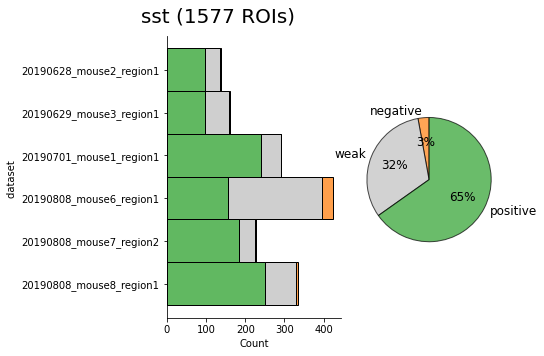

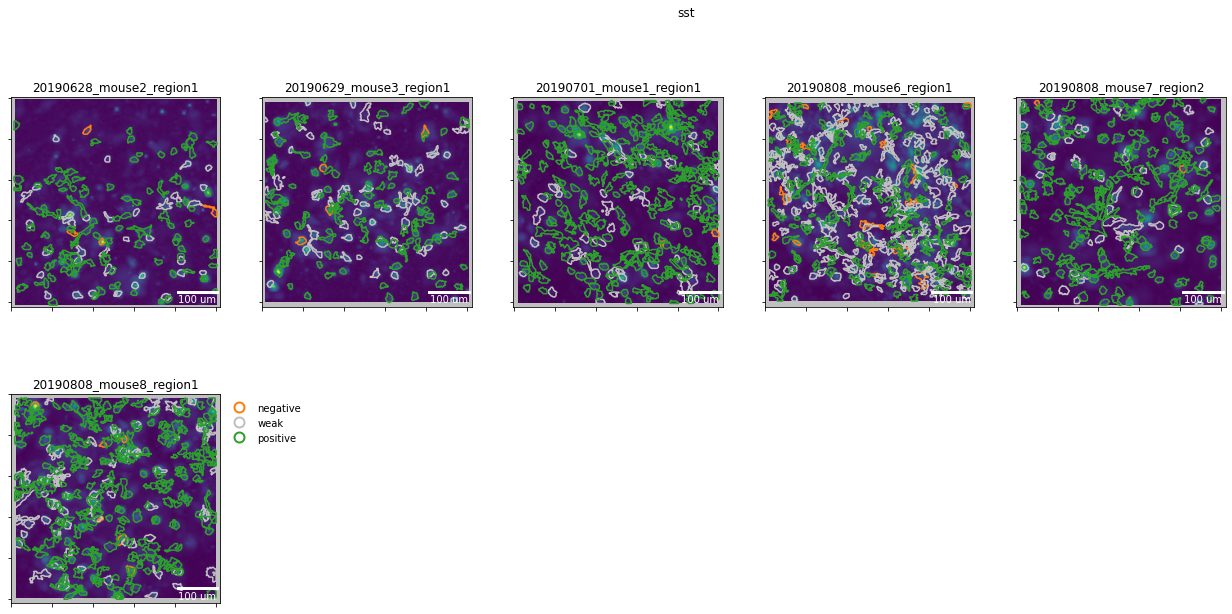

In [49]:
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    stats, hue=Label.ROI_RESP_TYPE, title=mouseline)
# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

### Identify extreme conditions (yelding many negative / positive responses) 

In [25]:
# # Get proportion of each response type per condition and dataset
# respcounts = stats[Label.RESP_TYPE].groupby([Label.DATASET, Label.RUN]).value_counts()
# totcounts = respcounts.groupby([Label.DATASET, Label.RUN]).sum()
# respprops = respcounts / totcounts
# respprops = respprops.unstack().fillna(0)
# # Get datasets & conditions yelding high proportions of positive and negative responders
# negresps = respprops[respprops['negative'] >= 0.5]['negative'].sort_values(ascending=False).to_frame()
# negresps['color'] = Palette.RTYPE['negative']
# posresps = respprops[respprops['positive'] >=0.5]['positive'].sort_values(ascending=False).to_frame()
# posresps['color'] = Palette.RTYPE['positive']
# extreme_conds = pd.concat([negresps, posresps], axis=0)
# extreme_conds

### Plot trial heatmap per condition for entire mouse line

 05/12/2022 16:51:00: 20190628_mouse2_region1: expanding 135100 rows (139 ROIs, 12 runs, 100 frames) series into 208500 rows (139 ROIs x 15 runs x 100 frames) series (73400 additional rows)
 05/12/2022 16:51:01: 20190629_mouse3_region1: expanding 205900 rows (162 ROIs, 14 runs, 100 frames) series into 243000 rows (162 ROIs x 15 runs x 100 frames) series (37100 additional rows)
 05/12/2022 16:51:02: 20190701_mouse1_region1: expanding 373400 rows (292 ROIs, 15 runs, 100 frames) series into 438000 rows (292 ROIs x 15 runs x 100 frames) series (64600 additional rows)
 05/12/2022 16:51:05: 20190808_mouse7_region2: expanding 290900 rows (227 ROIs, 15 runs, 100 frames) series into 340500 rows (227 ROIs x 15 runs x 100 frames) series (49600 additional rows)
 05/12/2022 16:51:06: 20190808_mouse8_region1: expanding 446100 rows (334 ROIs, 15 runs, 100 frames) series into 501000 rows (334 ROIs x 15 runs x 100 frames) series (54900 additional rows)
 05/12/2022 16:51:08: adding time info to table...

15it [00:08,  1.85it/s]                        


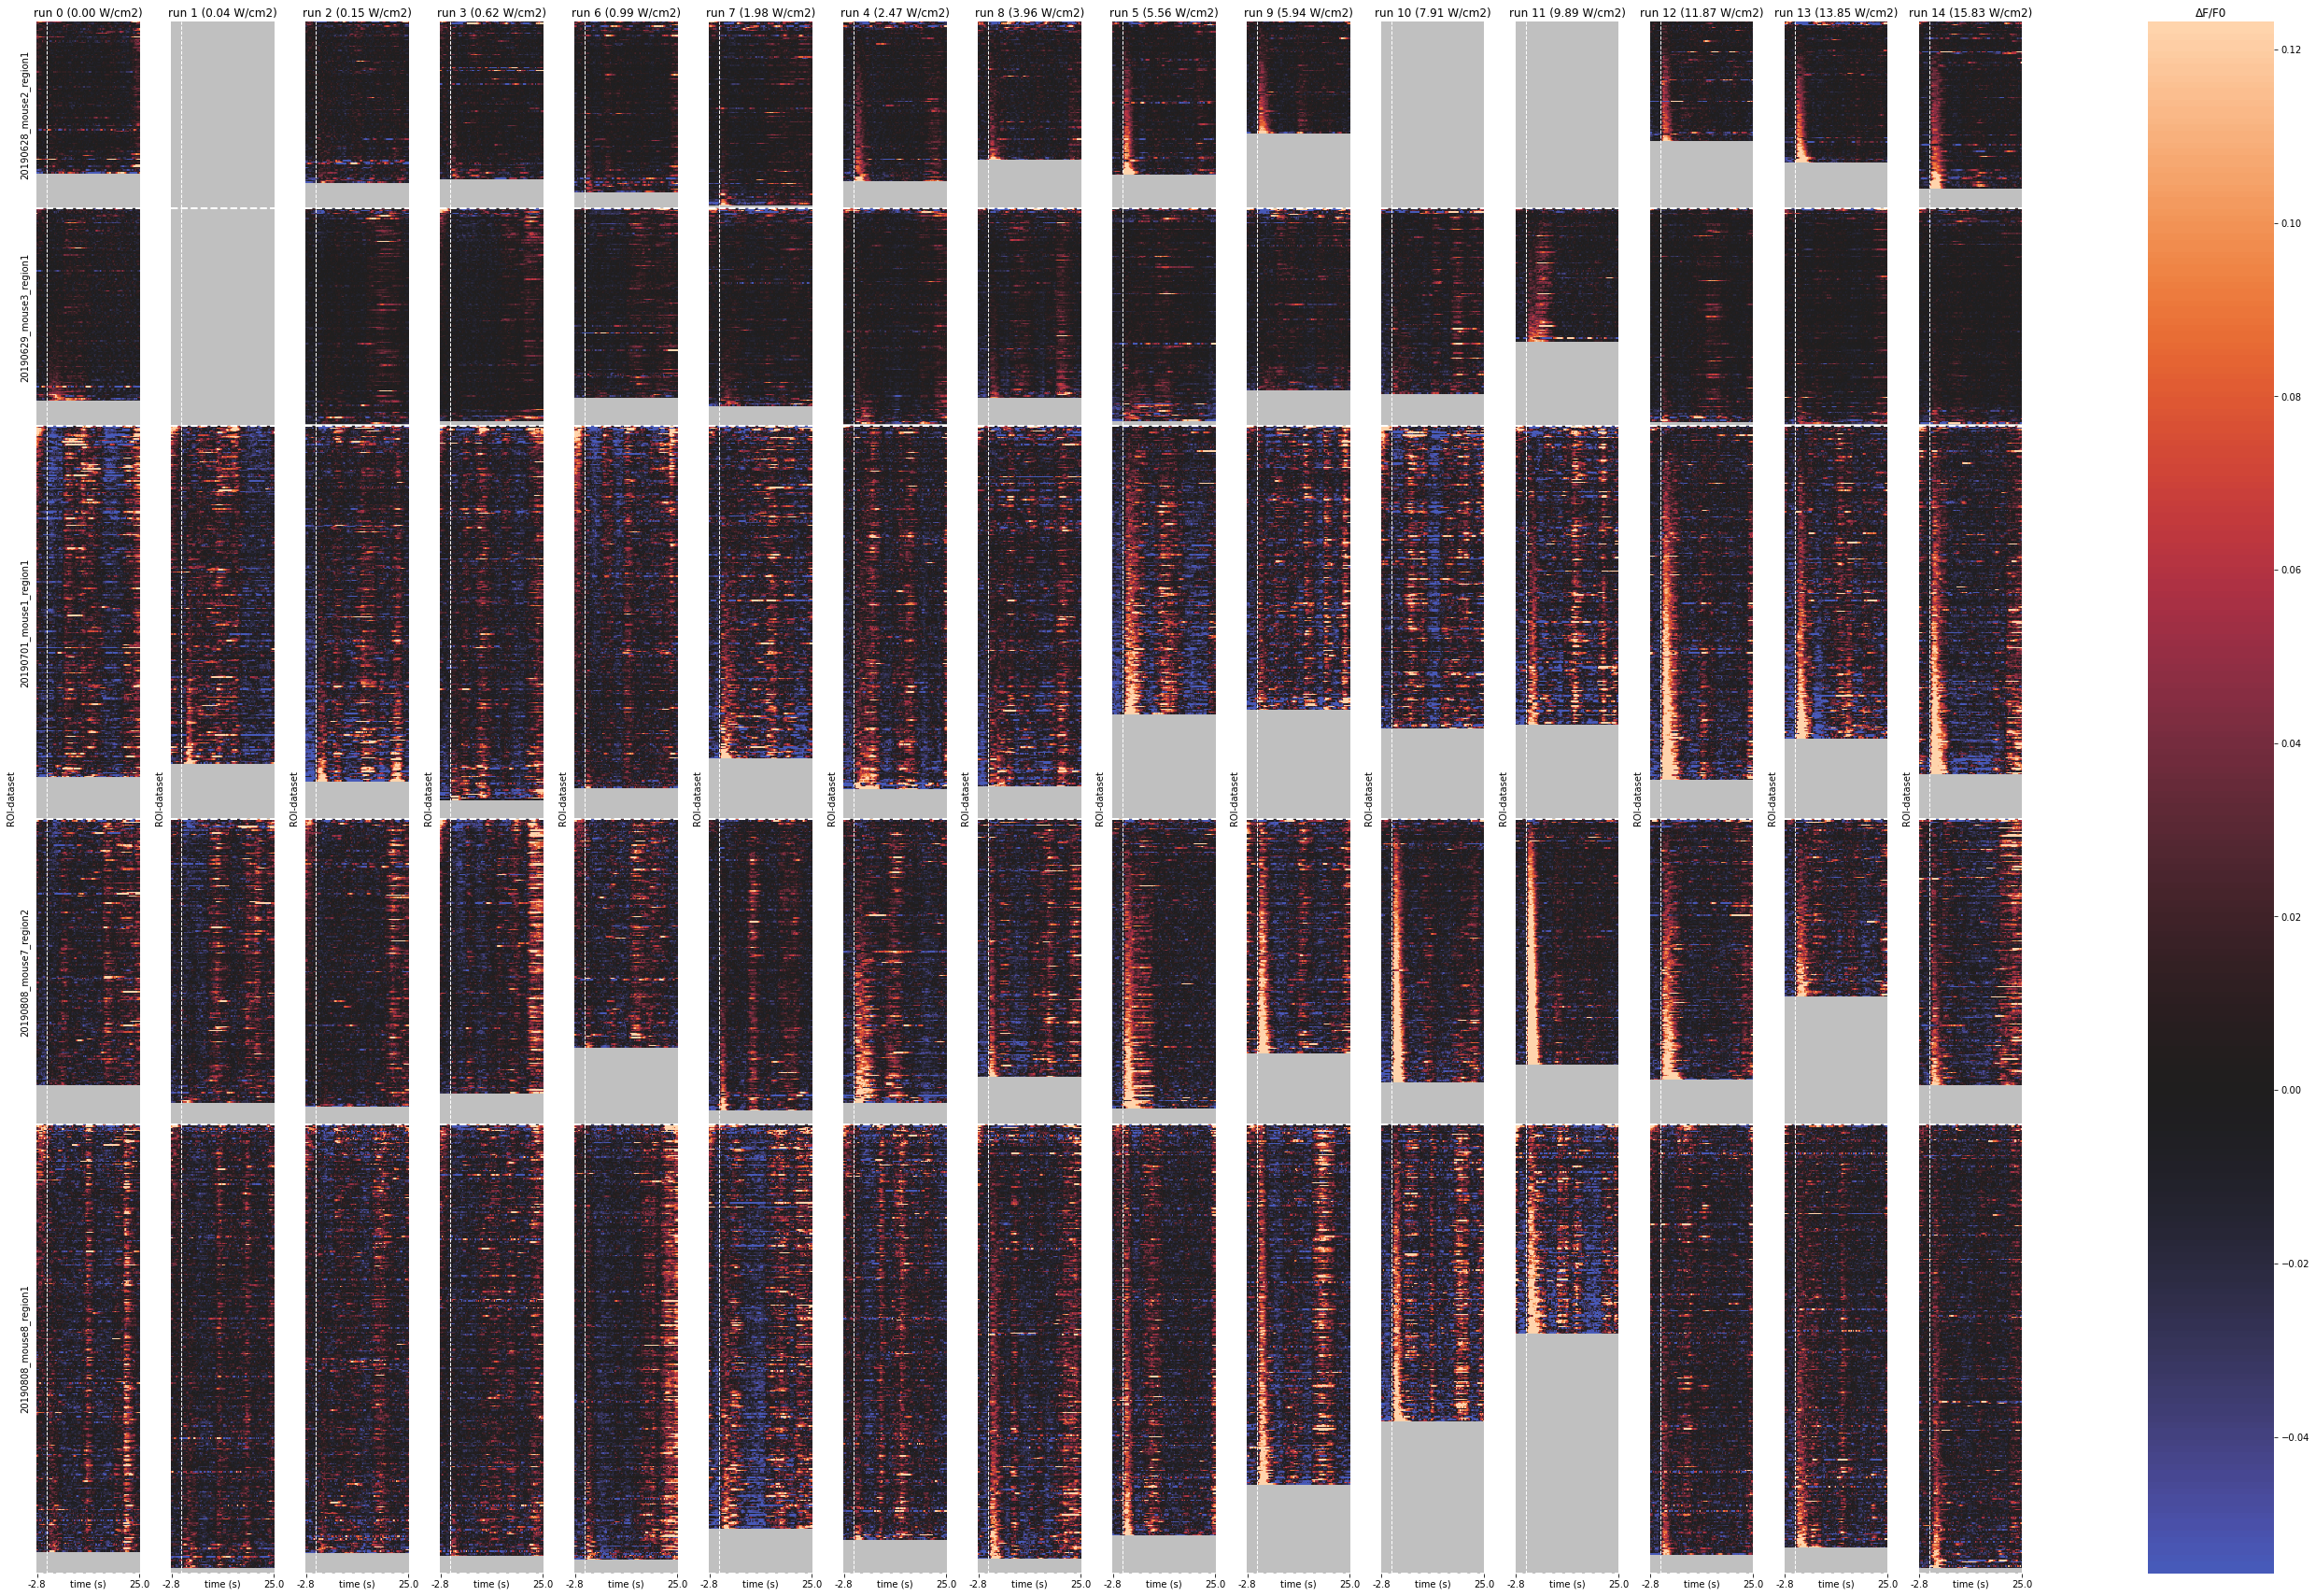

In [26]:
sorted_ISPTAs = stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(stats, Label.FPS)
for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_trial_heatmap(
        timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_rows=True,
        # rect_markers=extreme_conds['color']
    )

### Plot pressure and DC dependency curves

 05/12/2022 18:13:16: plotting ΔF/F0 stimulation parameters dependencies for negative responders...
 05/12/2022 18:13:18: plotting ΔF/F0 stimulation parameters dependencies for positive responders...
 05/12/2022 18:13:19: plotting ΔF/F0 stimulation parameters dependencies for weak responders...
 05/12/2022 18:13:21: plotting ΔF/F0 stimulation parameters dependencies across responders...


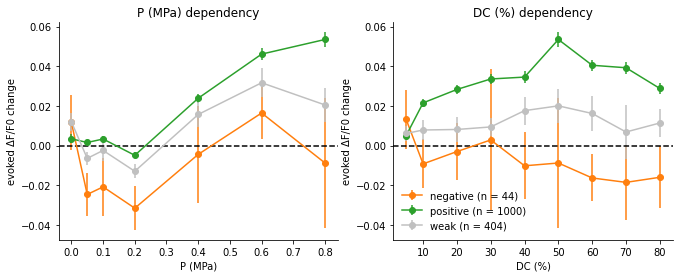

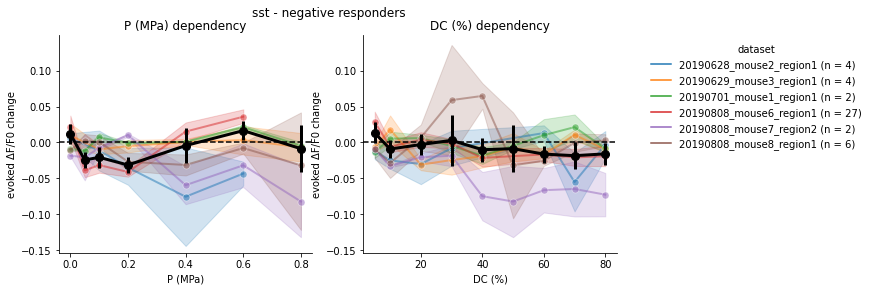

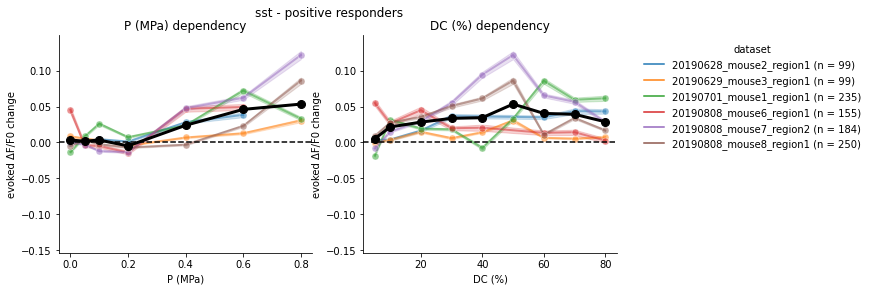

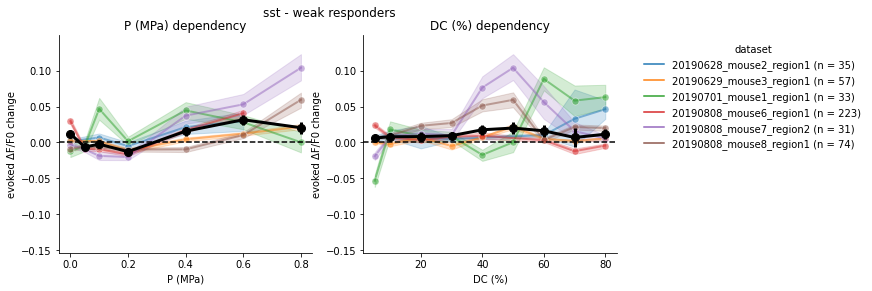

In [51]:
figs['stimparamdeps_global'], axes = plt.subplots(
    len(ykeys_plt), 2, figsize=(11, len(ykeys_plt) * 4))
axes = np.atleast_2d(axes)
for ykey, axrow in zip(ykeys_plt, axes):
    # Determine output metrics key
    ykey_diff = get_change_key(ykey)

    # Plot param dependencies across datasets for each responder type separately
    tmpaxes = []
    for rtype, substats in stats.groupby(Label.ROI_RESP_TYPE):
        figkey = f'{ykey}_stimparamdeps_{rtype}'
        logger.info(f'plotting {ykey} stimulation parameters dependencies for {rtype} responders...')
        logger.setLevel(logging.WARNING)
        figs[figkey] = plot_stimparams_dependency(
            substats, ykey_diff, yref=0, hue=Label.DATASET, 
            avgprop='whue', errprop='intra')
        figs[figkey].suptitle(f'{mouseline} - {rtype} responders')
        tmpaxes = tmpaxes + figs[figkey].axes
        logger.setLevel(logging.INFO)
    harmonize_axes_limits(np.asarray(tmpaxes))

    # Plot dependencies on each parameter on separate axes
    logger.info(f'plotting {ykey} stimulation parameters dependencies across responders...')
    plot_stimparams_dependency(
        stats, hue=Label.ROI_RESP_TYPE, ykey=ykey_diff, yref=0., axes=axrow);
for axrow in axes[1:]:
    for ax in axrow:
        ax.set_title(None)
for axrow in axes[:-1]:
    for ax in axrow:
        ax.set_xlabel(None)

### Plot intensity dependency curves

 05/12/2022 17:11:20: plotting evoked ΔF/F0 change ISPTA dependency across responders...


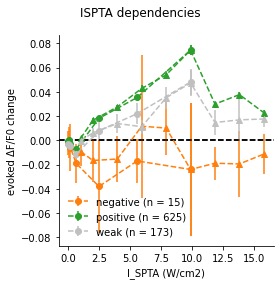

In [34]:
figs['ispta_deps'], axes = plt.subplots(1, len(ykeys_plt), figsize=(len(ykeys_plt) * 4, 4))
axes = np.atleast_1d(axes)
figs['ispta_deps'].suptitle(f'ISPTA dependencies')
for ykey, ax in zip(ykeys_plt, axes):
    plot_intensity_dependencies(stats, get_change_key(ykey), ax=ax)
figs['ispta_deps'].tight_layout()

### Plot response traces

 05/12/2022 17:11:28: merging timeseries and stats information...
 05/12/2022 17:11:32: adding time info to table...
 05/12/2022 17:11:33: plotting P (MPa) dependency curves for negative responders...
 05/12/2022 17:11:33: sub-indexing data...
 05/12/2022 17:11:33: filtering data...
 05/12/2022 17:11:33: cross-checking filters...
 05/12/2022 17:11:33: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 05/12/2022 17:11:33: plotting P (MPa) dependency curves for positive responders...
 05/12/2022 17:11:33: sub-indexing data...
 05/12/2022 17:11:33: filtering data...
 05/12/2022 17:11:33: cross-checking filters...
 05/12/2022 17:11:34: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 05/12/2022 17:11:36: plotting P (MPa) dependency curves for weak responders...
 05/12/2022 17:11:36: sub-indexing data...
 05/12/2022 17:11:36: filtering data...
 05/12/2022 17:11:36: cross-checking filters...
 05/12/2022 

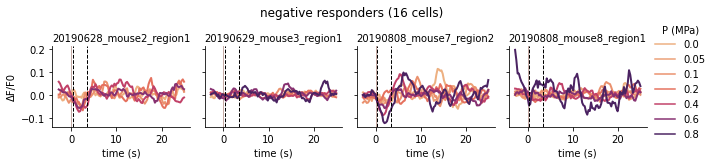

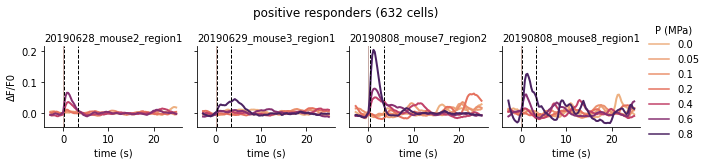

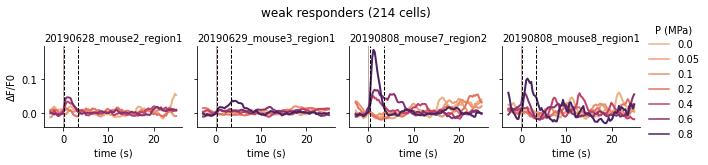

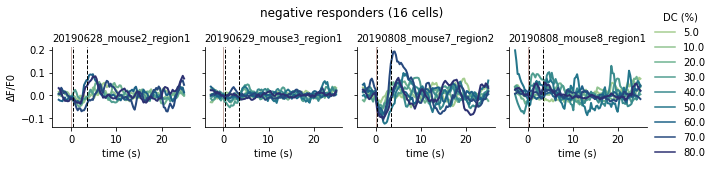

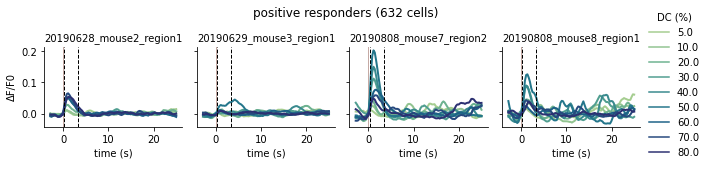

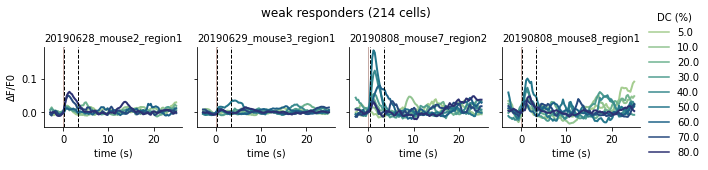

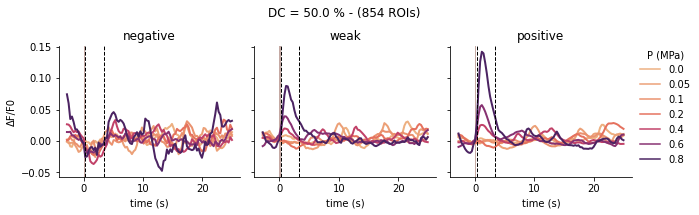

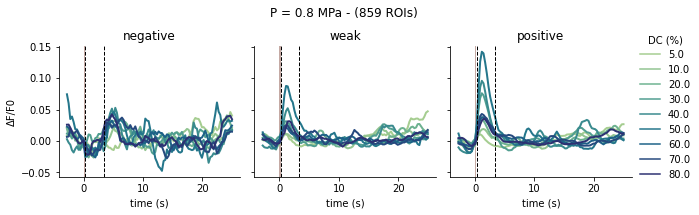

In [35]:
# Get plot-ready traces dataset
plt_data = get_plot_data(timeseries, stats)

# # Align DFF and z-score traces w.r.t their stimulus onset value
# plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
#     plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.STIM)

# For each output variable
for ykey in ykeys_plt:

    # Pressure-dependent response traces, per dataset
    figs.update(
        plot_responses_across_datasets(plt_data, ykey=ykey, pkey=Label.P))
    # DC-dependent response traces, per dataset
    figs.update(
        plot_responses_across_datasets(plt_data, ykey=ykey, pkey=Label.DC))

    # Global (weighted) response curves for both input stimulation parameters  
    for pkey in [Label.P, Label.DC]:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True)

### Save responder-type-averaged stats to disk

In [ ]:
rtypeavg_dir = get_output_equivalent(
    os.path.split(trialavg_dir)[0], 'trial-averaged', 'rtype-averaged')
fpath = os.path.join(rtypeavg_dir, f'{mouseline}.csv')
stats_per_rtype = get_cellcount_weighted_average(stats, Label.RUN, hue=Label.ROI_RESP_TYPE)
logger.info(f'saving responder-type-averaged stats to {fpath}...')
stats_per_rtype.to_csv(fpath)

 02/12/2022 11:19:19: saving responder-type-averaged stats to /Users/tlemaire/Documents/data/usnm/rtype-averaged/classΔFF0/alpha0.7_qadaptive_wq10.0s_ws10.00s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/sst.csv...


### Save figures

In [15]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 02/12/2022 11:20:25: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.12.02/figs_main_sst_k0.5_alpha0.7_qadaptive_wq10.0s_ws10.00s_classΔFF0.pdf:


100%|██████████| 23/23 [00:11<00:00,  2.06it/s]


### Notify upon completion

In [16]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 02/12/2022 11:20:39: sst batch notebook completed in 0:02:47.119836 s
